# Lab Project: Deconstructing the Transformer


Related video: https://www.youtube.com/watch?v=kCc8FmEb1nY

**"Attention is All You Need" – From Scratch**

- **Duration:** 2 Weeks
   
- **Tools:** Python, PyTorch (recommended) or TensorFlow/JAX
   
- **Dataset:** ["Tiny Shakespeare"](https://huggingface.co/datasets/karpathy/tiny_shakespeare) (Character-level text generation)
   


## 1. Project Overview

The goal of this lab is not to use a pre-built library like Hugging Face `transformers` to fine-tune a model. Instead, you will implement the Transformer architecture **layer-by-layer** using basic tensor operations.

By the end of this assignment, you will have a working **Decoder-Only Transformer** (a mini-GPT) capable of generating Shakespearean-style text. You will understand the exact flow of gradients through Self-Attention, Layer Normalization, and Residual Connections.


In [459]:
import requests
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import time
from datetime import datetime
from pathlib import Path
import pickle
import re
import pandas as pd
import seaborn as sns

In [277]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 32
block_size = 128
max_iters = 5000
eval_interval = 500
eval_iters = 200
learning_rate = 3e-4
n_embd = 384
n_head = 6
n_layer = 4
dropout = 0.2

In [276]:
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return(out)

## 2. The Dataset & Preprocessing

We will use the "Tiny Shakespeare" dataset. It is small, trains quickly on a CPU/low-end GPU, and allows for immediate visual verification (i.e., does the output look like English?).

**Task 0: Setup**

1. Download `input.txt` (Tiny Shakespeare).
   
2. Create a tokenizer: Build a dictionary mapping unique characters to integers (encoding) and integers back to characters (decoding).
   
3. Create a PyTorch `Dataset` or data loader that serves batches of context blocks (e.g., block size of 32 or 64 characters).

In [231]:
input_file = 'input.txt'
file_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

print(f'Downloading file {input_file} from {file_url}...')
with open(input_file,'w') as f:
    f.write(requests.get(file_url).text)

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [232]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'Total number of symbols : {len(chars)}')
print(chars)

Total number of symbols : 65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [233]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s: [stoi[x] for x in s]
decode = lambda i: ''.join([itos[x] for x in i])

print(stoi,'\n',itos)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64} 
 {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i

In [234]:
torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split=='train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y= x.to(device), y.to(device)
    return (x,y)


In [404]:
def generate_vocabulary(text):
    result = re.split(r"[?.:;, \n\-!']+", text)
    vocabulary = list(set(result))
    return(vocabulary)

## 3. Implementation Milestones

You must implement the architecture in an object-oriented fashion. Do not use `torch.nn.Transformer` or `torch.nn.MultiheadAttention`. You must build these classes yourself using `torch.nn.Linear`, `torch.matmul`, etc.


### Part I: Positional Embeddings

Transformers process tokens in parallel, meaning they have no inherent sense of order. You must inject this information.

- **Requirement:** Implement the sinusoidal positional encoding as described in the original paper _Attention is All You Need_.
   
- Formula:
   
    $$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
   
    $$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$
   
- **Deliverable:** A class `PositionalEncoding(d_model, max_len)` and a plot visualizing the embeddings (heatmap).

In [612]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.shape[1]
        return x + self.pe[:T, :]

    def plot_heatmap(self, length=100, file='positional_embedding_table.png'):
        plt.figure(figsize=(16,5))
        pos_embed = copy.deepcopy(self.pe[:length, :])
        plt.imshow(pos_embed.cpu().numpy(), cmap='viridis')
        plt.title('Sinusoidal Positional Embeddings')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Position (Time Step)')
        plt.colorbar()
        plt.savefig(file)
        plt.show()

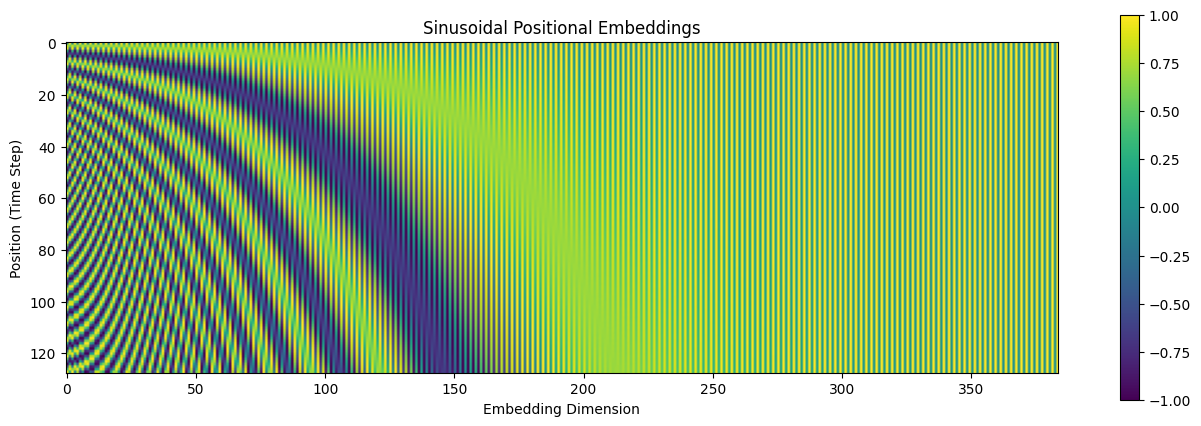

In [613]:
position_embedding_table = PositionalEncoding(d_model=384, max_len=128)
position_embedding_table.plot_heatmap(length=128, file='positional_embedding_table.png')

### Part II: Scaled Dot-Product Attention (The Core)

This is the mathematical engine of the Transformer.

- Requirement: Implement a function that takes Query ($Q$), Key ($K$), and Value ($V$) matrices and computes:
   
    $$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
   
- **Critical Detail:** You must implement a **Mask**. Since this is a decoder-only model for text generation, the model cannot "see the future." You must apply a lower-triangular mask (setting upper values to $-\infty$) before the softmax so that position $t$ can only attend to positions $0$ through $t$.


In [236]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v
        return out

### Part III: Multi-Head Attention (MHA)

Single-head attention captures one type of relationship. MHA allows the model to focus on different positions jointly from different representation subspaces.

- **Requirement:** Create a `MultiHeadAttention` class.
   
    1. Linear projections for $Q$, $K$, and $V$.
       
    2. Split the heads (reshape the tensors).
       
    3. Apply Scaled Dot-Product Attention (from Part II).
       
    4. Concatenate heads and apply a final linear projection.
       
- **Code Hint:** Be careful with tensor shapes.
   
    - Input: `(Batch, Time, Channels)`
       
    - Reshape to: `(Batch, Time, Heads, Head_Dim)`
       
    - Transpose for matmul: `(Batch, Heads, Time, Head_Dim)`


In [237]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Part IV: The Transformer Block

Assemble the components into a repeatable layer.

- **Requirement:** Create a `Block` class containing:
   
    1. **Layer Normalization:** Applied _before_ the sub-layer (Pre-Norm formulation is generally more stable than Post-Norm).
       
    2. **Multi-Head Attention:** Your class from Part III.
       
    3. **Feed-Forward Network:** A simple MLP expanding the dimension by 4x (e.g., `d_model` -> `4*d_model` -> `d_model`) with ReLU or GeLU activation.
       
    4. **Residual Connections:** $x + Sublayer(Norm(x))$.

In [238]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return(self.net(x))

In [239]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return(x)

### Helper functions

In [313]:
def generate_training_plots(train_losses, val_losses, iterations, file_name=None):    
    plt.figure(figsize=(16,9))
    plt.suptitle('Performance metrics')
    color = "tab:red"

    plt.ylabel("Loss", color=color)
    plt.plot(train_losses, color=color, label='Train accuracy')
    plt.plot(val_losses, color='tab:green', label='Validation accuracy')

    plt.xticks(range(len(iterations)),iterations)
    plt.tick_params(axis='y', labelcolor=color)
    plt.legend()
    
    plt.tight_layout()

    if file_name is not None:
        plt.savefig(file_name)
    
    plt.show()

## 4. Assembly and Training

### The Model

Create a `GPTLanguageModel` class that stacks:

1. Token Embeddings + Positional Encodings.
   
2. $N$ layers of your `Block` (Try $N=4$ to $6$).
   
3. Final Layer Norm.
   
4. Final Linear Head (projecting to vocabulary size).

In [360]:
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        #self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.position_embedding_table = PositionalEncoding(n_embd, max_len=block_size)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        x = self.position_embedding_table(tok_emb) #torch.arange(T, device=device)) # (T,C)
        #x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)        
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focs only on the last time step
            logits = logits[:, -1, :] # becomes (B,C)
            # apply softmax to the get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

### Training Loop

- **Hyperparameters:**
   
    - Batch size: 32 or 64
       
    - Block size (context length): 128 or 256
       
    - Embedding dimension ($d_{model}$): 384
       
    - Heads: 6
       
    - Learning Rate: 3e-4 (use AdamW optimizer)
       
- **Metric:** Calculate Cross Entropy Loss.


In [366]:
torch.manual_seed(1337)

max_iters = 5000
eval_interval = 500
eval_iters = 200
learning_rate = 3e-4
dropout = 0.2

batch_size = 8
block_size = 4
n_embd = 64
n_head = 4
n_layer = 3

# batch_size = 32
# block_size = 128
# n_embd = 384
# n_head = 6
# n_layer = 4

# batch_size = 64
# block_size = 256
# n_embd = 384
# n_head = 6
# n_layer = 4

print('Creating Model ...')
model = GPTLanguageModel()
model.to(device)

# create a PyTorch optimizer
print('Setting up optimizer...')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss_history = []
val_loss_history = []
train_time = []
eval_time = []
epochs = []

print('Starting training ...')
for iter in range(max_iters):
    
    # evaluuate loss on train and val
    if (iter % eval_interval == 0) | (iter == max_iters-1):
        eval_start = time.perf_counter()
        losses = estimate_loss()
        train_loss_history.append(losses['train'])
        val_loss_history.append(losses['val'])
        eval_end = time.perf_counter()
        eval_time.append(eval_end - eval_start)
        epochs.append(iter)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, train time {np.sum(train_time)/60:.2f}, eval time {np.sum(eval_time)/60:.2f}")
        
    iter_start = time.perf_counter()
    
    #sample a batch
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss =model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    iter_end = time.perf_counter()
    train_time.append(iter_end - iter_start)
    

Creating Model ...
Setting up optimizer...
Starting training ...
step 0: train loss 4.5226, val loss 4.5125, train time 0.00, eval time 0.04
step 500: train loss 2.6253, val loss 2.6245, train time 0.14, eval time 0.07
step 1000: train loss 2.4974, val loss 2.4930, train time 0.29, eval time 0.11
step 1500: train loss 2.4488, val loss 2.4062, train time 0.44, eval time 0.14
step 2000: train loss 2.4352, val loss 2.4148, train time 0.59, eval time 0.18
step 2500: train loss 2.3525, val loss 2.3672, train time 0.77, eval time 0.22
step 3000: train loss 2.3468, val loss 2.3745, train time 0.92, eval time 0.25
step 3500: train loss 2.3748, val loss 2.3951, train time 1.07, eval time 0.29
step 4000: train loss 2.3280, val loss 2.3805, train time 1.22, eval time 0.32
step 4500: train loss 2.3446, val loss 2.3584, train time 1.38, eval time 0.36
step 4999: train loss 2.3139, val loss 2.3465, train time 1.53, eval time 0.40


In [367]:
str_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'transformer_metrics_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.pkl'
performance_data = {'train_loss':train_loss_history,
                    'val_loss': val_loss_history,
                    'epochs':epochs,
                    'train_time':train_time,
                    'eval_time':eval_time
                    }
with open(file_name, 'wb') as f:
    pickle.dump(performance_data, f)

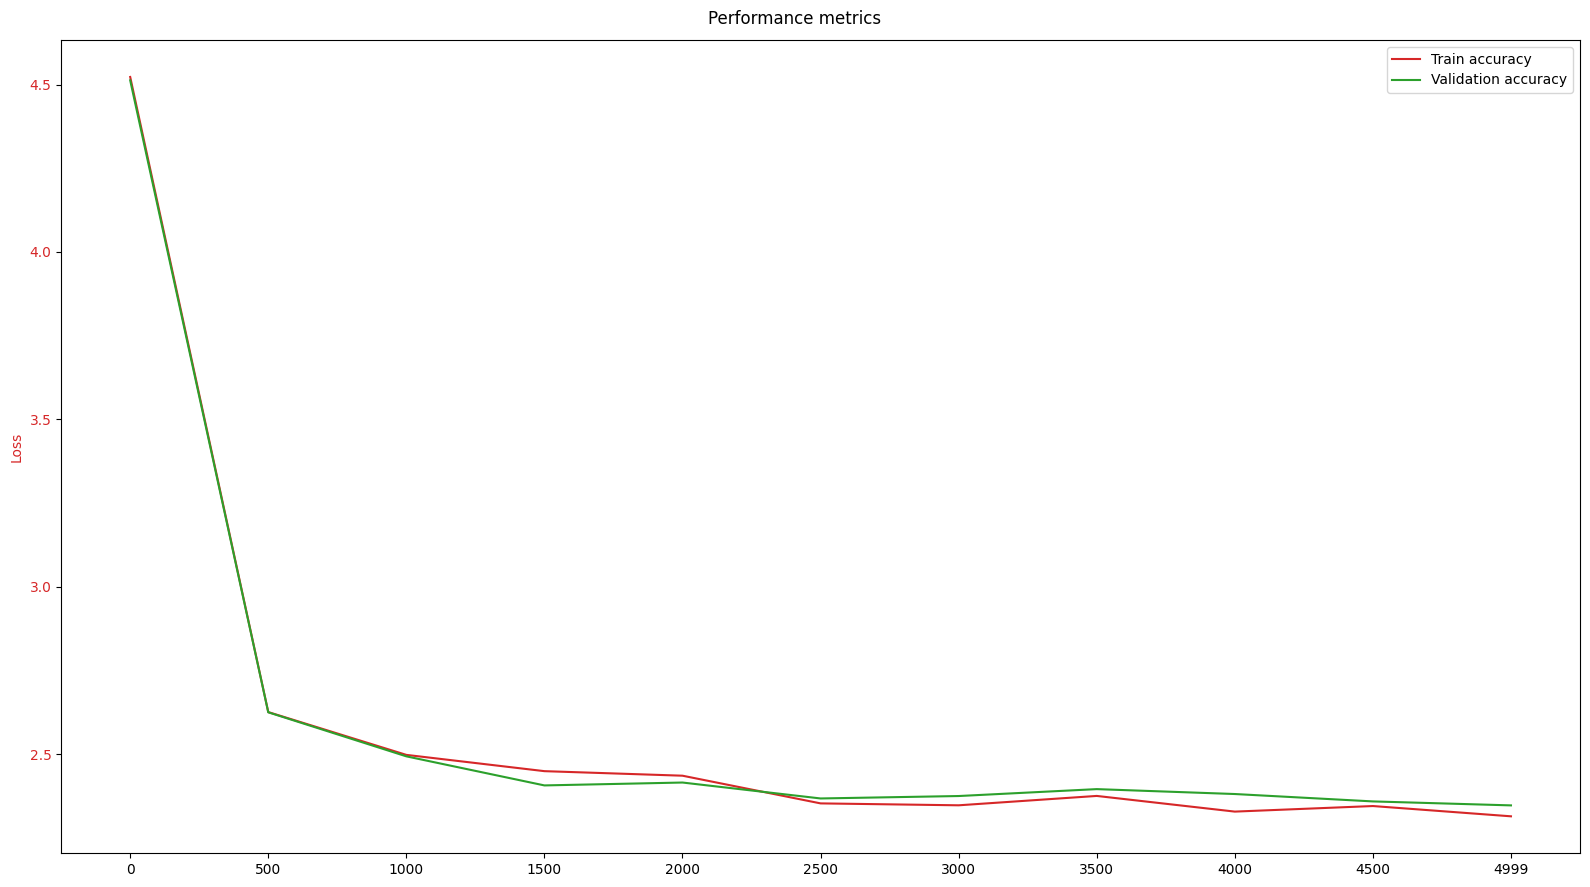

In [368]:
str_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'transformer_performance_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.png'
generate_training_plots(train_loss_history, val_loss_history, iterations=epochs, file_name=file_name)

### Saving the model

In [369]:
str_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.pth'
print(f'Saving {file_name}')
torch.save(model.state_dict(),file_name)

Saving transformer_8ba_4bl_64em_4he_3l_20254604_144614.pth


### Generation Function

Implement a `generate` function.

- Take a starting context (e.g., a single character).
   
- Pass through the model to get logits.
   
- Apply Softmax to get probabilities.
   
- Sample from the distribution (`torch.multinomial`).
   
- Append the new character and repeat.

## 5. Experimentation Report

### Methodology

The transformer architecture was built per the instructions above, creating a class for a mini GPT Decoder and as part of that work the Tiny Shakespeare data was loaded to be split into two sets: train and validation.  These sets were used to feed through the transformer network and ajust the weights, but also validate the results on unseen data.

In order to understand the transformer behavior better, three models were built, varying some of the parameters.  The transformer model is tweak by adjusting the following parameters:

- batch size
- block size
- embedding size
- number of heads
- number of layers

So we take three different model complexities and compare their training and validation losses, and also some sort of accuracy metric as explained next.

The train, validation and inference times as plotted as well to understand the time it takes to train/validate/use the model.

### Accuracy function

In order to measure the quality of the words generate, besides using the loss function in the training phase, we approximate how good the model is by seeing how many of the words generated are found on the original text.  This may not be the only metric one would use for this, but for this simple example, it can help to contrast the three models.

$$acc(g) = \frac{| W_g  \cap W_v |}{| W_g |}$$


### First Model

The first model is very simple, using a small batch and block size, and also a small embedding space, with the following settings:

| batch_size | block_size | n_embd | n_head | n_layer |
|:---:|:---:|:---:|:---:|:---:|
| 8 |  4 | 64 | 4 | 3 |

This model in general is able to generate a lot of giberish, but from a quick sample, about 25% of words generated are coming from the original text provided.

In [578]:
batch_size = 8
block_size = 4
n_embd = 64
n_head = 4
n_layer = 3

search_directory = Path('./')

#file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l.pth'
file_name_template = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l*.pth'
file_list = list(search_directory.glob(file_name_template))
print(file_list)
file_name = file_list[-1]
print(file_name)

print('Creating Model ...')
model_pred = GPTLanguageModel()
model_pred.to(device)
model_pred.load_state_dict(torch.load(file_name))

[WindowsPath('transformer_8ba_4bl_64em_4he_3l_20254604_144614.pth')]
transformer_8ba_4bl_64em_4he_3l_20254604_144614.pth
Creating Model ...


<All keys matched successfully>

In [579]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_text = decode(model_pred.generate(context, max_new_tokens=1000)[0].tolist())
print(generated_text)


VIUMEFS:
I rent bu, spers, ien; ponis andy, hat but ont bea?
TELI: Is fit iN dot thimend you treay eobs-enrl
vownd; pyoud benest yout hent tromoneed bey, arnd, thers e
Matmes ripee wedllequU
ce to yourch,-parl sthend is iyer
Yhaddedffr bovisbl, hohous Siosh chamy,
NUKES:
Ledes,
Thaker'
So tof dord ethr got hueverd ad in uped:
Go LORHA:
The hand bom none res you crefe: shen ate ewe ID:
I Magatht,
Gag theers cong ofour gpserapene tordeaninge.


RAs iruste!:
Hangerd
He port beber', featbodedan thour brin:
Ce hapor nof ordegede, furgs, youd,; jeiter, morS sowee.
My
Whake fou not ordg lrukivenrse:

Is blence acrmy thy eynenariringisede ethik reatkery aenes;
akting;
Wh stonir son CHad whelyS:
ABie Ieend.
We yof bue, it her drave asade mant, ionrgI ioey moull she nollesthe, mou elotith diadmenrso movitir? you cut, wis
On!
Why liRgh mob, thour hath beravanche ado pred,
'e too heeeeiner.


KIUK:
Cer mie good is cun hcof dedir fotee sitgorsoprlt ourot hrur.
Iss vedith
Bush,-
ve:
For aiomees, a;

In [580]:
original_vocab = generate_vocabulary(text)
generated_vocab = generate_vocabulary(generated_text)
found_words = [1 if x in original_vocab else 0 for x in generated_vocab]
percent_words_found = np.sum(found_words) / len(generated_vocab)
percent_words_found

np.float64(0.2606060606060606)

In [581]:
percent_words_found_m1 = []
inference_times_m1 = []

for i in range(50):
    if i%10==0: print(f'Iteration {i}')
    start_time = time.perf_counter()
    generated_text = decode(model_pred.generate(context, max_new_tokens=100)[0].tolist())
    end_time = time.perf_counter()
    generated_vocab = generate_vocabulary(generated_text)
    found_words = [1 if x in original_vocab else 0 for x in generated_vocab]

    percent_words_found_m1.append(np.sum(found_words) / len(generated_vocab))
    inference_times_m1.append(end_time-start_time)
    
np.mean(percent_words_found_m1)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40


np.float64(0.2954543589365571)

### Second Model

The second model is more complex,, using a larger  batch and block size, and also creating a much larger embedding space, with the following settings:

| batch_size | block_size | n_embd | n_head | n_layer |
|:---:|:---:|:---:|:---:|:---:|
| 32 |  128 | 384 | 6 | 4 |

This model in general is able to generate better words, even if the text completely doesn't make a lot of sense from a quick sample, about 70% of words generated are coming from the original text provided.

In [582]:
batch_size = 32
block_size = 128
n_embd = 384
n_head = 6
n_layer = 4

search_directory = Path('./')

#file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l.pth'
file_name_template = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l*.pth'
file_list = list(search_directory.glob(file_name_template))
print(file_list)
file_name = file_list[-1]
print(file_name)

print('Creating Model ...')
model_pred = GPTLanguageModel()
model_pred.to(device)
model_pred.load_state_dict(torch.load(file_name))

[WindowsPath('transformer_32ba_128bl_384em_6he_4l_20250803_210807.pth')]
transformer_32ba_128bl_384em_6he_4l_20250803_210807.pth
Creating Model ...


<All keys matched successfully>

In [583]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_text = decode(model_pred.generate(context, max_new_tokens=1000)[0].tolist())
print(generated_text)


VOLUMNIUS:
Now in nights;
Hath breen beneformitious to suffer me throne.
Have we here, I they lieged it greets in my brows;
And this I shoot do Warwick thus on him.

BISHOP OF MARWISLIA:
I have bed saved.
By my promise, come nowry.


FRIAR SICHOP MENENIUS:
Whom he, he shall be to log be one,
Him that place you sit to at your high'd.

BUCKINGHAM:
You will might thought'st log in here into me
Sin fone purposes the happor gave to myself
Is has up the order talks fortune:
You have mind addmnabling rights and come behind
Touchsafe, he name war to thee about's good.

Second Warwick, Camillo.

RICHMOMEO:
I were conqued, it seelf; your chensied no more
let a suitor, nor more my sonselesst me injest,
And never shall boaring proph'd understing to see
As'd our abidence slabes, then now Hail,
That as your fellior right in that life,
Go would hid he firm mercistacl'd.

Second Callifford:
He had his conveyal with him.

BRUTUS:
No, put the house of the wealthil.

Shepherd:
Away, your chardinesss
Cim

In [584]:
original_vocab = generate_vocabulary(text)
generated_vocab = generate_vocabulary(generated_text)
found_words = [1 if x in original_vocab else 0 for x in generated_vocab]
percent_words_found = np.sum(found_words) / len(generated_vocab)
percent_words_found

np.float64(0.7902097902097902)

In [585]:
percent_words_found_m2 = []
inference_times_m2 = []

for i in range(50):
    if i%10==0: print(f'Iteration {i}')
    start_time = time.perf_counter()
    generated_text = decode(model_pred.generate(context, max_new_tokens=100)[0].tolist())
    end_time = time.perf_counter()
    generated_vocab = generate_vocabulary(generated_text)
    found_words = [1 if x in original_vocab else 0 for x in generated_vocab]

    percent_words_found_m2.append(np.sum(found_words) / len(generated_vocab))
    inference_times_m2.append(end_time-start_time)
    
np.mean(percent_words_found_m2)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40


np.float64(0.8198650203164267)

### Third Model
The third model is the most complex of all with double the batch and block sizes, and same embedding space as the previous model, with the following settings:

| batch_size | block_size | n_embd | n_head | n_layer |
|:---:|:---:|:---:|:---:|:---:|
| 64 |  256 | 384 | 6 | 4 |

This model in general is the highest rated with about 77% of words generated are coming from the original text provided.

In [586]:
batch_size = 64
block_size = 256
n_embd = 384
n_head = 6
n_layer = 4

search_directory = Path('./')

#file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l.pth'
file_name_template = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l*.pth'
file_list = list(search_directory.glob(file_name_template))
print(file_list)
file_name = file_list[-1]
print(file_name)

print('Creating Model ...')
model_pred = GPTLanguageModel()
model_pred.to(device)
model_pred.load_state_dict(torch.load(file_name))

[WindowsPath('transformer_64ba_256bl_384em_6he_4l_20253204_033242.pth')]
transformer_64ba_256bl_384em_6he_4l_20253204_033242.pth
Creating Model ...


<All keys matched successfully>

In [587]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_text = decode(model_pred.generate(context, max_new_tokens=1000)[0].tolist())
print(generated_text)


Now, by this trough will make heart of those fate,
Before ourself walks, changed and fiend, that he
Narth purpose much more in worm.

OXFOR:
Richerd outrates, thy numble steeds avalone,
To black hart ic in sonsellor, and his palm.

HERMIONE:
Will thou, troubly, sirst to up, when never to all,
Into were death, sir, it were a glove in a Rome.

WARWICK:
And youngry son, fell then,
Peisus no good fall cat him distry.
But Fell him shall, we have are reason,
I master for repentitence myself.
The state frather, be removed and the king arth,
And, bring and few first to down.
So mee, unless  love what pain'd a child of women,
That are toempens and upon this browl guilt:
With cursets are stretching a pereseth-roone duke.

KING RICHARD II:
Methinks I hot would I vo dend thee ill,
Conceit this fault for the earth.
KING RICHARD III:
O no staby to of descree, a noble of thy death:
Is the coutst-or-whisty more doth,
To be coward tex of this prince and
Did rinkind whose deters death of Northily knife

In [588]:
original_vocab = generate_vocabulary(text)
generated_vocab = generate_vocabulary(generated_text)
found_words = [1 if x in original_vocab else 0 for x in generated_vocab]
percent_words_found = np.sum(found_words) / len(generated_vocab)
percent_words_found

np.float64(0.7602739726027398)

In [589]:
percent_words_found_m3 = []
inference_times_m3 = []

for i in range(50):
    if i%10==0: print(f'Iteration {i}')
    start_time = time.perf_counter()
    generated_text = decode(model_pred.generate(context, max_new_tokens=100)[0].tolist())
    end_time = time.perf_counter()
    generated_vocab = generate_vocabulary(generated_text)
    found_words = [1 if x in original_vocab else 0 for x in generated_vocab]

    percent_words_found_m3.append(np.sum(found_words) / len(generated_vocab))
    inference_times_m3.append(end_time-start_time)
    
np.mean(percent_words_found_m3)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40


np.float64(0.8513835002623198)

### Results

#### Generated words found in original vocabulary

In general, it's easy to see that if the model gets more complex, the performance will most likely get better, in the chart, you can see an improvement from Model 1 to Models 2 and 3, however, just a slight difference in the mean between Models 2 and 3.

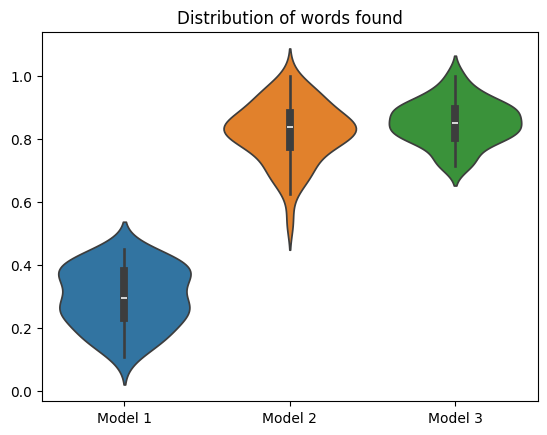

<Figure size 640x480 with 0 Axes>

In [606]:
results = pd.DataFrame({'Model 1': percent_words_found_m1, 'Model 2': percent_words_found_m2, 'Model 3': percent_words_found_m3})
plt.title('Distribution of words found')
sns.violinplot(data=results)
plt.show()
plt.savefig('output_word_comparison.png')

#### Inference time

Another important metric to look at is inference time.  For this particular scenario, inference time was calculated for 50 samples of 100 words each, and for each of those samples the inference time for all models was below 2 seconds.  Specifically, Model 1 is very fast, less than 0.7 seconds in average for those 100 characters, while Models 2 and 3 have similar distributions with around 1.2 secods for the inference, but it can be see that there are times when the inference can lag up to 1.8 seconds. 

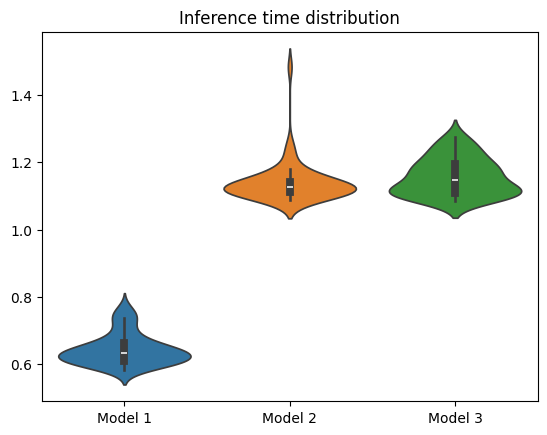

<Figure size 640x480 with 0 Axes>

In [605]:
results = pd.DataFrame({'Model 1': inference_times_m1, 'Model 2': inference_times_m2, 'Model 3': inference_times_m3})
plt.title('Inference time distribution')
sns.violinplot(data=results)
plt.show()
plt.savefig('inference_time_comparison.png')

#### Loading loss & results

In [592]:
model_settings = { 
                'Model 1': {
                    'batch_size':8,
                    'block_size':4,
                    'n_embd':64,
                    'n_head':4,
                    'n_layer':3
                    },
                'Model 2': {
                    'batch_size':32,
                    'block_size':128,
                    'n_embd':384,
                    'n_head':6,
                    'n_layer':4
                    },
                'Model 3': {
                    'batch_size':64,
                    'block_size':256,
                    'n_embd':384,
                    'n_head':6,
                    'n_layer':4
                    }
                }

model_results = {}

for m in model_settings.keys():
    batch_size = model_settings[m]['batch_size']
    block_size = model_settings[m]['block_size']
    n_embd = model_settings[m]['n_embd']
    n_head = model_settings[m]['n_head']
    n_layer = model_settings[m]['n_layer']

    file_name_template = f'transformer_metrics_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l*.pkl'
    file_list = list(search_directory.glob(file_name_template))
    file_name = file_list[-1]
    print(file_name)
    
    with open(file_name, 'rb') as f:
        results = pickle.load(f)

    model_results[m] = results

transformer_metrics_8ba_4bl_64em_4he_3l_20254604_144604.pkl
transformer_metrics_32ba_128bl_384em_6he_4l_20250703_210756.pkl
transformer_metrics_64ba_256bl_384em_6he_4l_20253204_033241.pkl


In [593]:
model_results['Model 1'].keys()

dict_keys(['train_loss', 'val_loss', 'epochs', 'train_time', 'eval_time'])

#### Losses

It can be seen that Model 1 converged early to a loss around 2.4, but would definitely not make better progress, while Models 2 and 3 had smaller losses after the 5,000 iterations.  Unfortunately, even after achieving a smaller loss, Model 3 still performs similarly as Model 2 when presented with unknown data, so the model did overfit the training data.

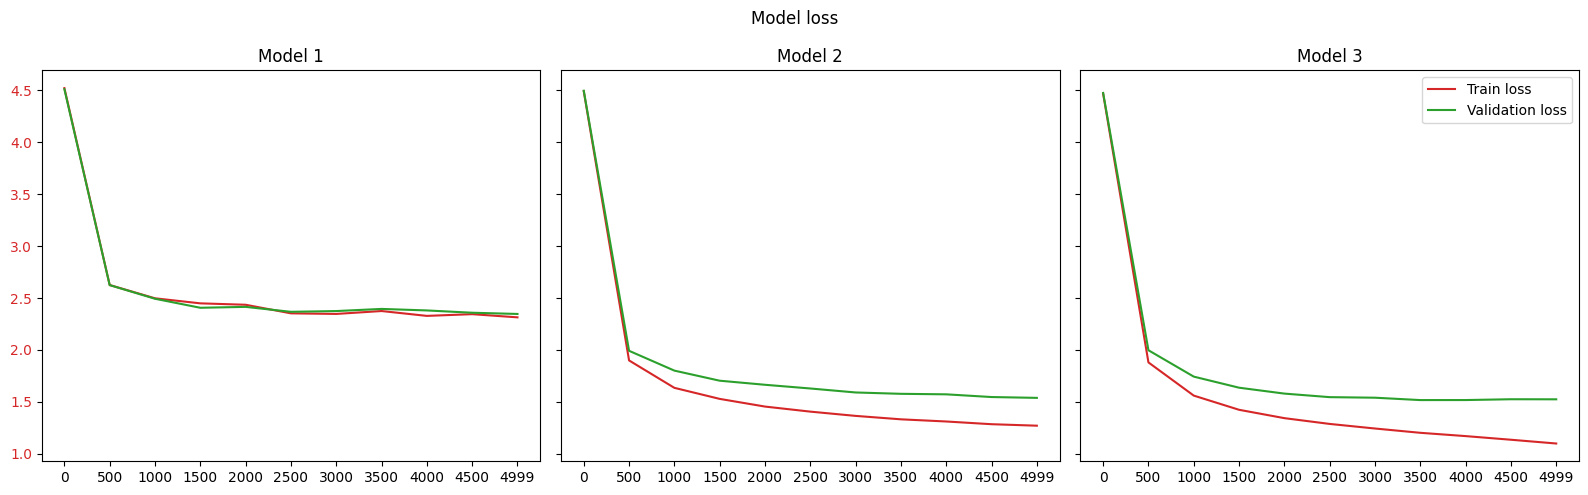

In [601]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(16,5))
fig.suptitle('Model loss')

for i,j in enumerate(model_results.keys()):    
    #ax[i].ylabel("Loss", color=color)
    ax[i].plot(model_results[j]['train_loss'], color=color, label='Train loss')
    ax[i].plot(model_results[j]['val_loss'], color='tab:green', label='Validation loss')
    ax[i].set_title(j)

    ax[i].set_xticks(range(len(model_results[j]['epochs'])),model_results[j]['epochs'])
    ax[i].tick_params(axis='y', labelcolor=color)
    
plt.legend()
fig.tight_layout()
plt.savefig('loss_comparison.png')

#### Train times

Clearly, as the model gets more complex, training time will grow, in this case, each iteration would take close to 3.5 seconds per iteration for Model 3, which was the highest value, Model 2 was much faster around 1 second per iteration, while Model 1 was extremely fast.  As we will see, this is not the highest cost on traning the model.

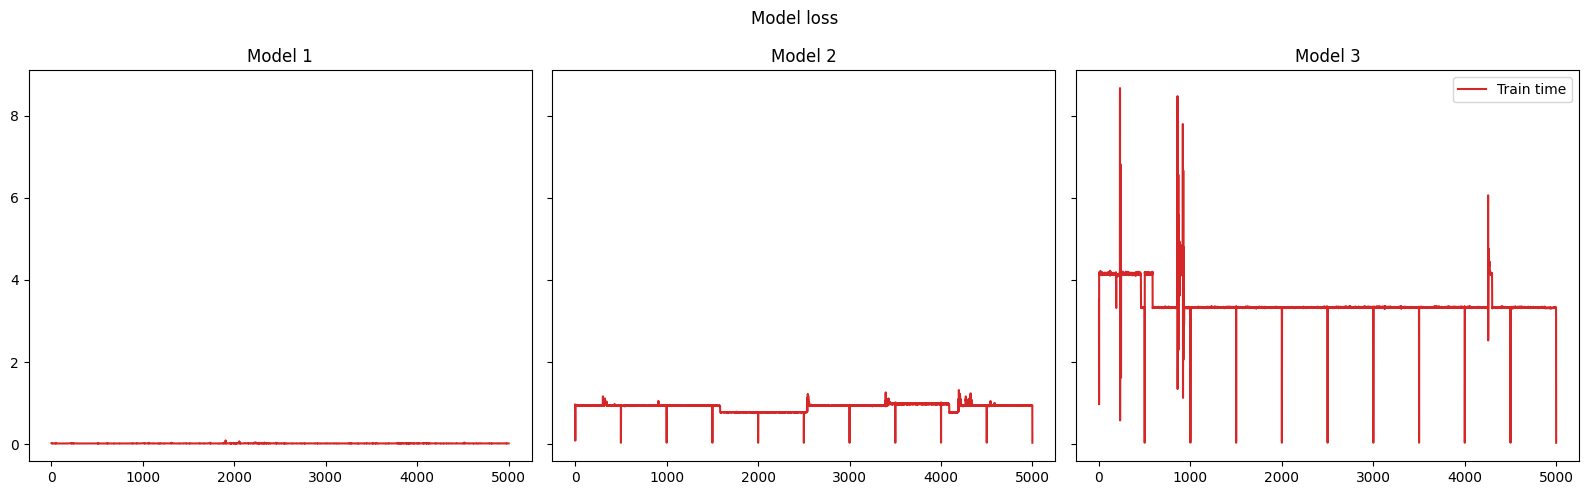

In [602]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(16,5))
fig.suptitle('Model loss')

for i,j in enumerate(model_results.keys()):    
    #ax[i].ylabel("Loss", color=color)
    ax[i].plot(model_results[j]['train_time'], color=color, label='Train time')
    #ax[i].plot(model_results[j]['eval_time'], color='tab:green', label='Validation time')
    ax[i].set_title(j)

    #ax[i].set_xticks(range(5000),range(5000))
    #ax[i].tick_params(axis='y', labelcolor=color)
    
plt.legend()
fig.tight_layout()
plt.savefig('train_time_comparison.png')

#### Eval times

For evey certain training iterations as we calculated an estimated validation and training loss, and running through the model for each of the 200 samples took around 8 minutes in average for Model 3, for model 2 around 2 minutes, and for Model 1 almost unnoticeable.

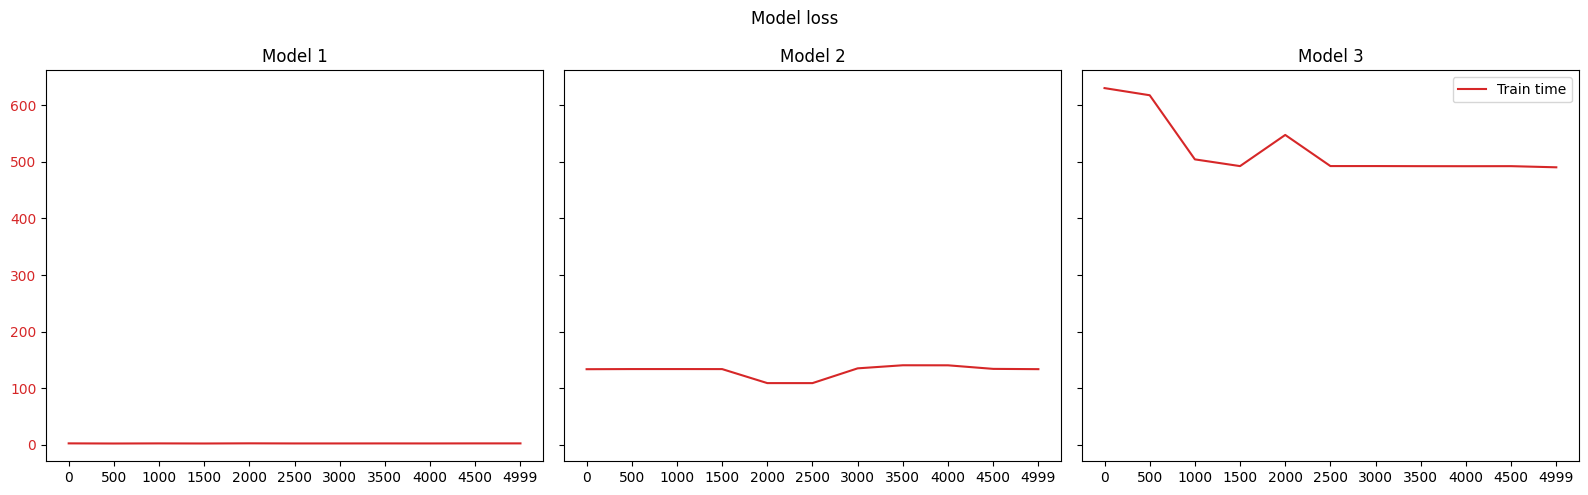

In [603]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(16,5))
fig.suptitle('Model loss')

for i,j in enumerate(model_results.keys()):    
    #ax[i].ylabel("Loss", color=color)
    ax[i].plot(model_results[j]['eval_time'], color=color, label='Train time')
    #ax[i].plot(model_results[j]['eval_time'], color='tab:green', label='Validation time')
    ax[i].set_title(j)

    ax[i].set_xticks(range(len(model_results[j]['epochs'])),model_results[j]['epochs'])
    ax[i].tick_params(axis='y', labelcolor=color)
    
plt.legend()
fig.tight_layout()
plt.savefig('eval_time_comparison.png')

#### Total eval and train times

Total times can bee seen in the graph, without question, the more complex model, exponentially outgrows the simpler one, just by adding layers and sizes to the blocks and batch sizes

In [597]:
models = []
total_train = []
total_val = []

for i,j in enumerate(model_results.keys()):
    models.append(j)
    total_train.append(np.sum(model_results[j]['train_time'])/60)
    total_val.append(np.sum(model_results[j]['eval_time'])/60)

results = pd.DataFrame({'Model':models, 'Total train time':total_train, 'Total val time':total_val})
results['Total time'] = results['Total train time'] + results['Total val time']
results

,Model,Total train time,Total val time,Total time
0,Model 1,1.530320,0.397732,1.928052
1,Model 2,75.805662,23.918256,99.723918
2,Model 3,285.878339,95.769804,381.648143


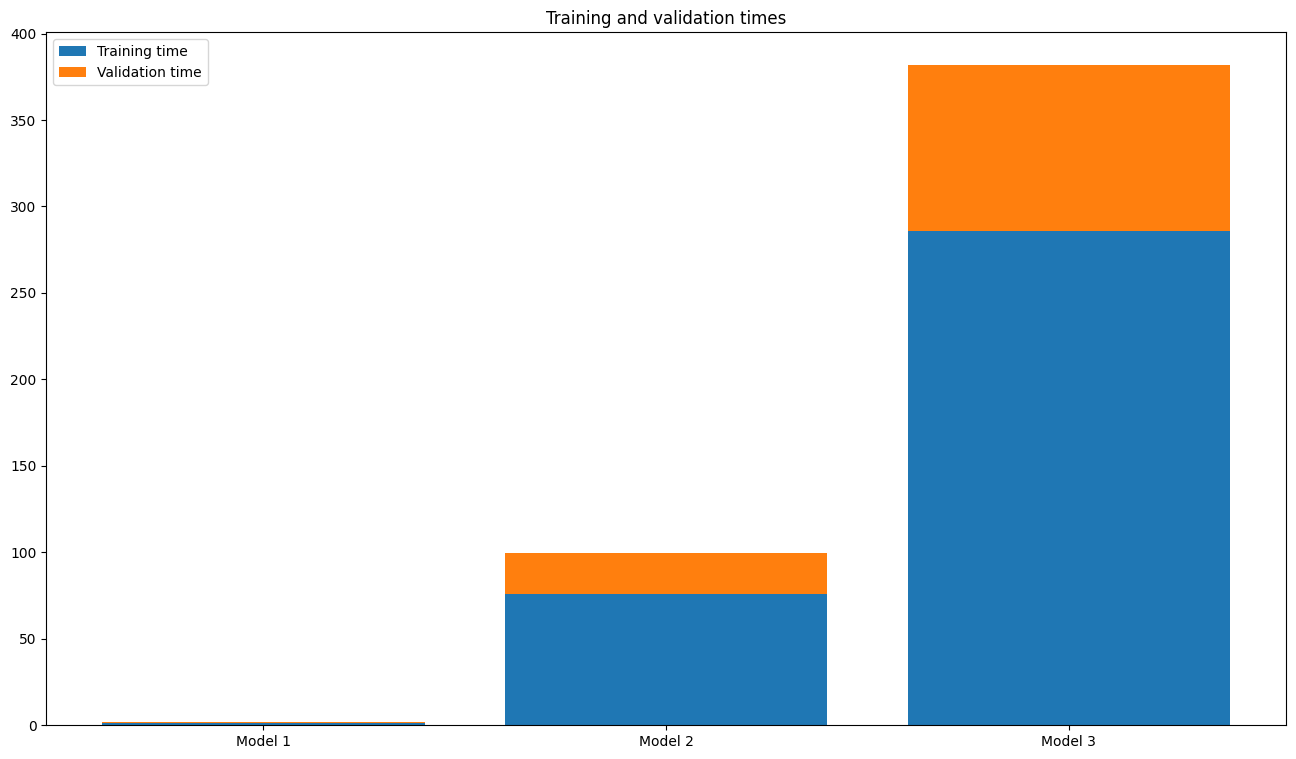

In [604]:
plt.figure(figsize=(16,9))
plt.title('Training and validation times')
categories = results['Model']
data_s1 = results['Total train time']
data_s2 = results['Total val time']
plt.bar(categories, data_s1)
plt.bar(categories, data_s2, bottom=data_s1)
plt.legend(['Training time','Validation time'])
fig.tight_layout()
plt.savefig('total_times_comparison.png')

### Analysis Questions (Include in Report)

1. **Scaling:** Why do we divide by $\sqrt{d_k}$ in the attention formula? What happens to the Softmax gradients if we don't?
   

Given that we are multiplying the Query and Key matrices before normalization, assuming that these matrices are 0 mean and variance of 1, we would be exploding the values in the multiplication now making the variance $d_k$.  This would also affect the softmax function, by making it output larger, the softmax output will get to a place where gradients explode

2. **Positional Encoding:** Why do we add positional encodings to the embeddings rather than concatenating them?


Positional encodings provide addition information to the model as to where certain words/letters appear respect to others.  If we were to concatenate the matrices, we would be adding more computation complexity to the model, so instead of having a matrix of $d_model + d_pos$, we can just add the embeddings to the $d_model$ matrix, and even though this will get baked into the model, it will be able to eventually learn this subtle additions.

3. **Complexity:** What is the Big-O time complexity of the Self-Attention mechanism with respect to the sequence length $T$? Why is this a problem for very long texts?

The complexity of the self-attention calculation is $O(T^2 \cdot d)$, and this is because to calculate the relation between a token and every other token we have to multiply a matrix $T \times T$, so if a sentence grows, say twice the size, $T$ will also grow and the attention calculation quadruples

## 6. Starter Code Snippet (Helper)

Here is the signature for your Multi-Head Attention to get you started:

Python

```
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size * num_heads, bias=False)
        self.query = nn.Linear(n_embd, head_size * num_heads, bias=False)
        self.value = nn.Linear(n_embd, head_size * num_heads, bias=False)
        # You need to register the mask as a buffer so it's not treated as a parameter
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
       
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # B: Batch, T: Time (Sequence Length), C: Channels (Embed size)
        B, T, C = x.shape
       
        # Implementation goes here...
        pass
```